In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import  AdamW
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import numpy as np
import spacy
import re
import math
import gc
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from transformers import BertTokenizer
import ast
from torch.nn.utils.rnn import pad_sequence
import os
import matplotlib.pyplot as plt

In [2]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model, dropout=0.1, max_len=24000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=23187):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros((max_len, d_model)) 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


    
    
class TransformerTextClassifier(nn.Module):
    def __init__(self,ntoken, ninp, nhead, nhid, nlayers, num_classes, dropout=0.5, norm_first=True):
        super(TransformerTextClassifier, self).__init__()
        self.pos_encoder = PositionalEncoding(ninp)
        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_first=norm_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.fc = nn.Linear(ninp, num_classes-1)
        self.activation =nn.GELU() 
        #self.activation =nn.LeakyReLU()
        
        self.init_weights()

    def forward(self, src, src_mask):

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output.mean(dim=1)  # Pooling layer (e.g., mean pooling)
        output = self.fc(output)
        # output = torch.sigmoid(output)  
        return output

    def init_weights(self):
        initrange = 0.1
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                m.bias.data.zero_()


    # def init_weights(self):
    #     initrange = 0.1
    #     self.fc.weight.data.uniform_(-initrange, initrange)
    #     self.fc.bias.data.zero_()



class IDDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        id = self.input_ids[idx]
        label = self.labels[idx]

        return {
            'input_ids': id,
            'labels': label
        }

class TextDataset(Dataset):
    def __init__(self, token_ids, labels):
        self.token_ids = token_ids
        self.labels = labels

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, idx):
        token_id = self.token_ids[idx]
        label = self.labels[idx]
        
        return {
            'input_ids': torch.tensor(token_id, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [3]:
nlp = spacy.load("en_core_web_sm")

In [2]:
def preprocess_text(txt:str):

    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = txt.lower()
    txt = " ".join(txt.split())

    doc = nlp(txt)

    tokens_filtered = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue

        tokens_filtered.append(token.lemma_)

    return " ".join(tokens_filtered)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_and_convert(text):
    # Tokenize the text using spaCy
    spaCy_tokens = [token.text for token in nlp(text)]
    
    # Convert spaCy tokens to strings
    token_strings = [str(token) for token in spaCy_tokens]
    
    # Map token strings to numerical IDs using the pre-trained tokenizer
    token_ids = tokenizer.convert_tokens_to_ids(token_strings)
    
    return token_ids

In [4]:
# Load the CSV file
data = pd.read_csv('mental-health.csv')
# Display the first few rows of the DataFrame
print(data.head())
data = data.drop_duplicates(ignore_index = True)
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
df_null_values



                                                text         label
0  I recently went through a breakup and she said...    depression
1  I do not know how to navigate these feelings, ...    depression
2  So I have been with my bf for 5 months , and h...    depression
3  I am so exhausted of this. Just when I think I...  SuicideWatch
4  I have been severly bullied since i was 5 till...    depression


,count,%
text,0,0.0
label,0,0.0


In [5]:
data['text_prep'] = data['text'].apply(preprocess_text)


In [6]:
data['token_id'] =  data['text_prep'].apply(tokenize_and_convert)



In [7]:
LABELS = data['label'].unique()
label2id = dict(zip(LABELS, np.arange(len(LABELS), dtype = np.float32)))
data['label_prep'] = data['label'].map(label2id)


In [8]:
data.dropna(subset=['text_prep'], inplace=True)

In [9]:
data.to_csv('preprocessed_data.csv', index=False)

In [4]:
##########
## load data if the preprocessed instead of reprocessed
data = pd.read_csv('preprocessed_data.csv')


In [35]:
# data[data['token_id'].isna()]['token_id'].head()
# data['token_id'] = data['token_id'].fillna('[]')

In [5]:
def convert_string_to_array(s):
    return np.array(ast.literal_eval(s))

data['token_id']  = data['token_id'] .apply(convert_string_to_array)

In [6]:
data.head()

,text,label,text_prep,token_id,label_prep
0,I recently went through a breakup and she said...,depression,recently go breakup say want friend say try ta...,"[3728, 2175, 19010, 2360, 2215, 2767, 2360, 30...",0.0
1,"I do not know how to navigate these feelings, ...",depression,know navigate feeling new feeling stretch unde...,"[2113, 22149, 3110, 2047, 3110, 7683, 3305, 27...",0.0
2,"So I have been with my bf for 5 months , and h...",depression,bf month tell depressed week particular happen...,"[28939, 3204, 2425, 14777, 2733, 3327, 4148, 2...",0.0
3,I am so exhausted of this. Just when I think I...,SuicideWatch,exhausted think finally rest think maybe thing...,"[9069, 2228, 2633, 2717, 2228, 2672, 2518, 270...",1.0
4,I have been severly bullied since i was 5 till...,depression,severly bully till result depressed misanthrop...,"[100, 20716, 6229, 2765, 14777, 100, 100, 3674...",0.0


In [7]:
X = data['token_id']
y = data['label_prep']


SEED = 1235
train_ids_0, test_ids, train_labels_0, test_labels = tts(X, y, test_size = 0.1, random_state = SEED)
train_ids, val_ids, train_labels, val_labels = tts(train_ids_0, train_labels_0, test_size = 0.2, random_state = SEED)

In [39]:
# Hyperparameters
num_attention_heads = int(np.random.uniform(2, 4))
num_attention_heads = 8
embedding_size = int(np.random.uniform(120, 170)) # ninp should be bigger
embedding_size = embedding_size - embedding_size % num_attention_heads
nhidden = int(np.random.uniform(50, 300))
nhidden = 70
nlayers = int(np.random.uniform(2, 12))
nlayers = 4
Dropout = np.random.uniform(0.1, 0.12)
#criterion = nn.CrossEntropyLoss() #FIXME
criterion = nn.BCEWithLogitsLoss() 
learning_rate = np.random.uniform(1e-3, 0.01)
learning_rate = 3e-3
num_epochs = 4
batch_size = 32




In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(1)


In [40]:

#old
# vectorizer = TfidfVectorizer()
# train_vectorizer = vectorizer.fit_transform(train_texts)
# val_vectorizer   = vectorizer.transform(val_texts)
# test_vectorizer  = vectorizer.transform(test_texts)

# train_vectorizer = train_vectorizer.toarray()
# val_vectorizer   = val_vectorizer.toarray()
# test_vectorizer  = test_vectorizer.toarray()

# _, ntoken = train_vectorizer.shape


# train_dataset = TextDataset(train, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataset = TensorDataset(torch.tensor(val_vectorizer, dtype=torch.float), torch.tensor(val_labels_array, dtype=torch.float))
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_dataset = TensorDataset(torch.tensor(test_vectorizer, dtype=torch.float), torch.tensor(test_labels_array, dtype=torch.float))


#new
ntoken = len(nlp.vocab)
ntoken= 37585
val_labels_array = val_labels.values.astype(float)
test_labels_array = test_labels.values.astype(float)

# train_dataset = TextDataset(train_ids, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = TextDataset(val_ids, val_labels)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# test_dataset = TextDataset(test_ids, test_labels) 
padded_train = pad_sequence([torch.tensor(seq) for seq in train_ids], batch_first=True, padding_value=0)
padded_val = pad_sequence([torch.tensor(seq) for seq in val_ids], batch_first=True, padding_value=0)
padded_test = pad_sequence([torch.tensor(seq) for seq in test_ids], batch_first=True, padding_value=0)

train_dataset = TensorDataset(torch.tensor(padded_train, dtype=torch.float), torch.tensor(train_labels, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(padded_val, dtype=torch.float), torch.tensor(val_labels_array, dtype=torch.float))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset =TensorDataset(torch.tensor(padded_test, dtype=torch.float), torch.tensor(test_labels_array, dtype=torch.float))


/tmp/ipykernel_2654787/3857427028.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(padded_train, dtype=torch.float), torch.tensor(train_labels, dtype=torch.float))
/tmp/ipykernel_2654787/3857427028.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(padded_val, dtype=torch.float), torch.tensor(val_labels_array, dtype=torch.float))
/tmp/ipykernel_2654787/3857427028.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset =TensorDataset(torch.t

In [41]:
# Print the hyperparameters
print("Hyperparameters:")
print(f"num_attention_heads= {num_attention_heads}")
print(f"embedding_size= {embedding_size}")
print(f"nhidden= {nhidden}")
print(f"nlayers= {nlayers}")
print(f"dropout= {Dropout}")
print("criterion=", criterion)
print(f"learning_rate= {learning_rate}")
print(f"num_epochs= {num_epochs}")
print(f"batch_size= {batch_size}")
print(f"ntoken= {ntoken}")

Hyperparameters:
num_attention_heads= 8
embedding_size= 160
nhidden= 70
nlayers= 4
dropout= 0.11010602677056984
criterion= BCEWithLogitsLoss()
learning_rate= 0.003
num_epochs= 4
batch_size= 32
ntoken= 37585


In [42]:
# model = TransformerModel(ntoken, embedding_size, num_attention_heads, nhidden, nlayers, Dropout, norm_first=True).to(device)
model = TransformerTextClassifier( ntoken, embedding_size, num_attention_heads, nhidden, nlayers,2, Dropout, norm_first=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/danielochana/anaconda3/envs/conda_deep/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [43]:
# ## in order to run on a trained checkpoint: 
# num_attention_heads= 8
# embedding_size= 160
# nhidden= 70
# nlayers= 4
# dropout= 0.24840944810773966
# batch_size= 16
# ntoken= 37585
# learning_rate= 0.0002
# model = TransformerTextClassifier( ntoken, embedding_size, num_attention_heads, nhidden, nlayers,2, Dropout, norm_first=True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# checkpoint = torch.load("model_checkpoint3.pth")
# model.load_state_dict(checkpoint)

<All keys matched successfully>

In [30]:
losses =[]
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_correct=0.0
    total_samples=0.0

    for batch_idx, (texts, labels) in enumerate(train_loader):
        model.train()
        # Convert texts and labels to tensors if necessary
        texts = texts.to(device).long()  
        labels = labels.to(device)

        
        optimizer.zero_grad()
        outputs = model(texts, None)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 50 == 1:
            accuracy = total_correct / total_samples
            losses.append(loss.item())
            train_accuracies.append(accuracy)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}, train_acc: {100. * accuracy:.2f}%")
            total_correct = 0.0
            total_samples = 0.0

 
    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for texts, labels in val_loader:
            texts = texts.to(device).long()  
            labels = labels.to(device)
            outputs = model(texts, None)
            outputs = torch.sigmoid(outputs) 
            predictions = (outputs > 0.5).float()
            total_correct += (predictions[:,0] == labels).sum().item()
            total_samples += labels.size(0)
            accuracy = total_correct / total_samples
    print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')



Epoch [1/3], Batch [2/458], Loss: 8.212056159973145, train_acc: 50.00%
Epoch [1/3], Batch [52/458], Loss: 0.8670637607574463, train_acc: 48.31%
Epoch [1/3], Batch [102/458], Loss: 0.6990375518798828, train_acc: 51.62%
Epoch [1/3], Batch [152/458], Loss: 0.6668969988822937, train_acc: 52.50%
Epoch [1/3], Batch [202/458], Loss: 0.7227464318275452, train_acc: 52.94%
Epoch [1/3], Batch [252/458], Loss: 1.142146110534668, train_acc: 52.19%
Epoch [1/3], Batch [302/458], Loss: 0.674197256565094, train_acc: 55.44%
Epoch [1/3], Batch [352/458], Loss: 0.8416059613227844, train_acc: 59.13%
Epoch [1/3], Batch [402/458], Loss: 0.5665631890296936, train_acc: 57.69%
Epoch [1/3], Batch [452/458], Loss: 0.7693417072296143, train_acc: 60.00%
total_correct 2469, total_samples : 3663, Val Acc: 67.40%
Epoch [2/3], Batch [2/458], Loss: 0.5110169649124146, train_acc: 67.19%
Epoch [2/3], Batch [52/458], Loss: 0.6297664642333984, train_acc: 64.94%
Epoch [2/3], Batch [102/458], Loss: 0.5829904675483704, train_a

In [ ]:
import math
def accurary_est(y_pred, y_label):
  y_pred = [0 if torch.sigmoid(i) < 0.5 else 1 for i in torch.tensor(y_pred)]
  return sum([1 for res in range(len(y_pred)) if y_pred[res] == y_label[res]]) / len(y_pred)

NameError: name 'train_accuracies' is not defined

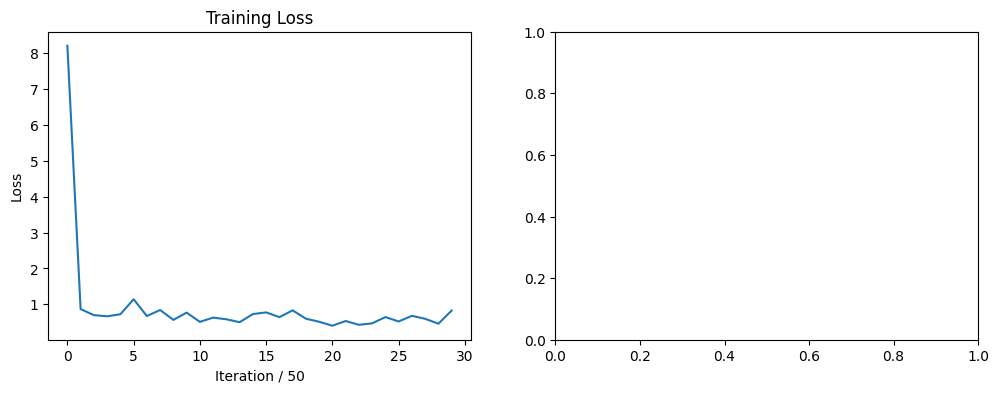

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(losses)
ax1.set_xlabel('Iteration / 50')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')

# Plot train accuracies
ax2.plot(train_accuracies)
ax2.set_xlabel('Iteration / 50')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.tight_layout()
plt.show()



In [31]:
# Save the model
torch.save(model.state_dict(), 'model_checkpoint8.pth')

In [32]:
# Final training results
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for texts, labels in train_loader:
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        accuracy = total_correct / total_samples
        # print(predictions[:,0])
        # print(f'total_correct [{predictions.shape}, total_samples : {labels.shape}')
print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')

total_correct 10961, total_samples : 14651, Val Acc: 74.81%


In [33]:
# Validation
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for texts, labels in val_loader:
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        accuracy = total_correct / total_samples
        # print(predictions[:,0])
        # print(f'total_correct [{predictions.shape}, total_samples : {labels.shape}')
print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')

total_correct 2560, total_samples : 3663, Val Acc: 69.89%


In [23]:
# Test results
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for texts, labels in test_loader:
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        accuracy = total_correct / total_samples
print(f'total_correct {total_correct}, total_samples : {total_samples}, test Acc: {100. * accuracy:.2f}%')

total_correct 1450, total_samples : 2035, test Acc: 71.25%


In [4]:
torch.cuda.empty_cache()


In [16]:
def deallocate_tensors():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) :
            if obj.device.type == 'cuda':
                del obj  # This removes the reference to the tensor
    torch.cuda.empty_cache()  # This releases any remaining GPU memory not in use

deallocate_tensors()



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [17]:
print(torch.cuda.memory_reserved()/(1024 ** 3))

# Release cached memory
torch.cuda.empty_cache()
gc.collect()

# After releasing cached memory
print(torch.cuda.memory_reserved()/(1024 ** 3))

0.14453125


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:

def check_gpu_capacity():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        properties = torch.cuda.get_device_properties(device)
        total_memory = properties.total_memory / (1024 ** 3)  # Convert bytes to gigabytes
        memory_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # Allocated memory in use
        memory_cached = torch.cuda.memory_reserved(device) / (1024 ** 3)  # Cached but not currently in use
        free_memory = total_memory - memory_allocated - memory_cached
        print(f"Total GPU Memory: {total_memory:.2f} GB")
        print(f"Allocated Memory: {memory_allocated:.2f} GB")
        print(f"Cached Memory: {memory_cached:.2f} GB")
        print(f"Free Memory: {free_memory:.2f} GB")
    else:
        print("CUDA is not available.")
# gc.collect()
check_gpu_capacity()


Total GPU Memory: 10.91 GB
Allocated Memory: 0.06 GB
Cached Memory: 0.14 GB
Free Memory: 10.71 GB


In [ ]:
# import torch.nn as nn
# class block(nn.Module):
# 	def __init__(self):
# 		super(block, self).__init__()
# 		self.attention = nn.MultiheadAttention(embeds_size, num_heads, batch_first=True)
# 		self.ffn = nn.Sequential(
# 			nn.Linear(embeds_size, 2 * embeds_size),
# 			nn.LeakyReLU(),
# 			nn.Linear(2 * embeds_size, embeds_size),
# 		)
# 		self.drop1 = nn.Dropout(drop_prob)
# 		self.drop2 = nn.Dropout(drop_prob)
# 		self.ln1 = nn.LayerNorm(embeds_size)
# 		self.ln2 = nn.LayerNorm(embeds_size)

# 	def forward(self, hidden_state):
# 		attn, _ = self.attention(hidden_state, hidden_state, hidden_state, need_weights=False)
# 		attn = self.drop1(attn)
# 		out = self.ln1(hidden_state + attn)
# 		observed = self.ffn(out)
# 		observed = self.drop2(observed)
# 		return self.ln2(out + observed)
	

# class transformer(nn.Module):
#     def __init__(self):
#         super(transformer, self).__init__()

#         self.tok_emb = nn.Embedding(vocab_size, embeds_size)
#         self.pos_emb = nn.Embedding(block_size, embeds_size)
#         self.block = block()
#         self.ln1 = nn.LayerNorm(embeds_size)
#         self.ln2 = nn.LayerNorm(embeds_size)

#         self.classifier_head = nn.Sequential(
#             nn.Linear(embeds_size, embeds_size),
#             nn.LeakyReLU(),
#             nn.Dropout(drop_prob),
#             nn.Linear(embeds_size, embeds_size),
#             nn.LeakyReLU(),
#             nn.Linear(embeds_size, num_classes),
#             nn.Softmax(dim=1),
#         )

#         print("number of parameters: %.2fM" % (self.num_params()/1e6,))

#     def num_params(self):
#         n_params = sum(p.numel() for p in self.parameters())
#         return n_params

#     def forward(self, seq):
#         B,T = seq.shape
#         embedded = self.tok_emb(seq)
#         embedded = embedded + self.pos_emb(torch.arange(T, device=device))
#         output = self.block(embedded)
#         output = output.mean(dim=1)
#         output = self.classifier_head(output)
#         return output
    

# model = transformer()
# model.to(device)
# vocab_size = 20000

# block_size = 200
# embeds_size = 100
# num_classes = 2
# drop_prob = 0.13
# batch_size = 32
# epochs = 30
# num_heads = 4
# head_size = embeds_size // num_heads
# model_path = 'model_classification.pth'
# model_loader = False


#     for epoch in range(epochs):
# 	losses = 0
# 	for (inputs, targets) in train_data:
# 		inputs = inputs.to(device)
# 		targets = targets.to(device)
# 		output = model(inputs)
# 		loss = model_loss(output, targets)
# 		model_optimizer.zero_grad()
# 		loss.backward()
# 		model_optimizer.step()
# 		losses += loss.item()
# 	print(f'[{epoch}][Train]', losses)
# 	model.eval()
# 	test_loss = 0
# 	passed = 0
# 	for (inputs, targets) in test_data:
# 		with torch.no_grad():
# 			inputs = inputs.to(device)
# 			targets = targets.to(device)
# 			outputs = model(inputs)
# 			if outputs.argmax() == targets.argmax():
# 				passed += 1
# 	model.train()
# 	print(f'[{epoch}][Test]', ', accuracy', passed / len(dataset_y))